### Problem Statement
Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of 
chemicals leading to the emergence of resistant pathogen strains, increased input costs, 
and more outbreaks with significant economic loss and environmental impacts. Current disease 
diagnosis based on human scouting is time-consuming and expensive, and although 
computer-vision based models have the promise to increase efficiency, the great variance 
in symptoms due to age of infected tissues, genetic variations, and light conditions within 
trees decreases the accuracy of detection.

### Specific Objectives
Objectives of ‘Plant Pathology Challenge’ are to train a model using images of training dataset 
to 1) Accurately classify a given image from testing dataset into different diseased category or 
a healthy leaf; 2) Accurately distinguish between many diseases, sometimes more than one on a 
single leaf; 3) Deal with rare classes and novel symptoms; 4) Address depth perception—angle, 
light, shade, physiological age of the leaf; and 5) Incorporate expert knowledge in identification, 
annotation, quantification, and guiding computer vision to search for relevant features during learning.




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import re

import albumentations as A
import cv2

import math
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader

from os import path


np.random.seed(12)
torch.manual_seed(12)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# https://medium.com/swlh/how-to-use-pytorch-dataloaders-to-work-with-enormously-large-text-files-bbd672e955a0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
file_path = '/content/gdrive/My Drive/projects/plant-pathology-2020-fgvc7/'

In [ ]:
train_df = pd.read_csv(file_path + '/train.csv')
test_df = pd.read_csv(file_path + '/test.csv')

In [ ]:
train_df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [ ]:
def load_image(image_id):
    image_file = image_id + ".jpg"
    image = cv2.imread(file_path + 'images/' + image_file)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
train_images = train_df["image_id"][:100].progress_apply(load_image)

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]



## Now to visualise some of the dataset to see the different classes 


In [ ]:
labels = train_df.iloc[:,1:].idxmax(1)

In [ ]:
chosen_label = ['healthy', 'rust', 'scab', 'multiple_diseases']

name_list = []
for lab in chosen_label:
  for num, name in enumerate(labels):
    if name == lab:
      name_list.append([name,num])
      if len(name_list) % 3 == 0 and len(name_list) != 0:
        break    

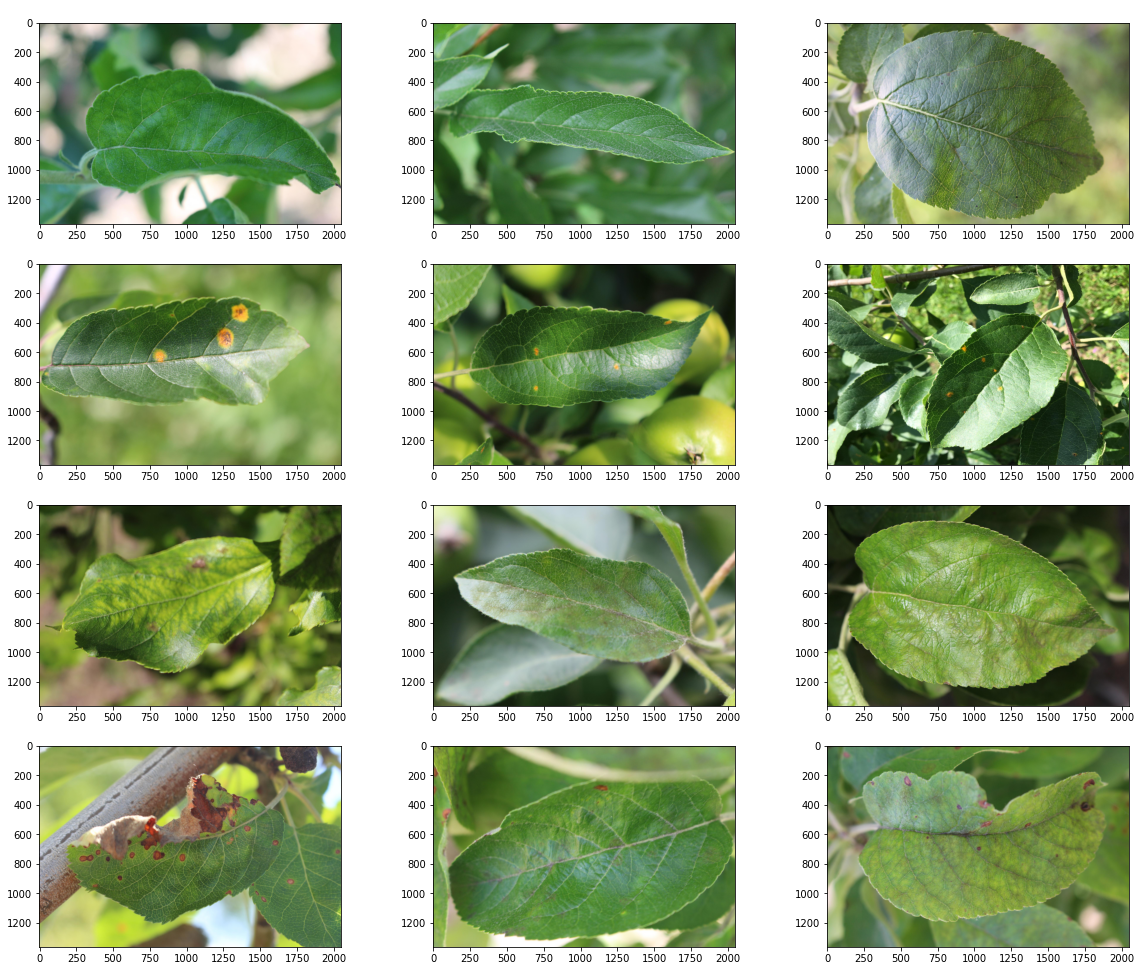

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(20,17))
i = 0
for row in range(ax.shape[0]):
  for col in range(ax.shape[1]):
    ax[row, col].imshow(train_images[name_list[i][1]])
    ax[row, col].set_title(name_list[i][0], color='white')
    i += 1

plt.show()

### From the class distribution below we can see that it is imbalanced with "multiple_diseases" having < 100 instances
### We will try weighting the minority class in the loss function to handle this.


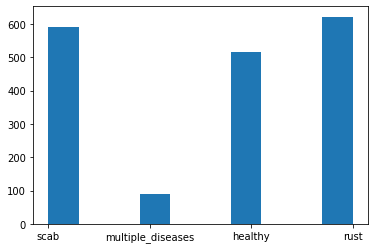

In [ ]:
plt.hist(labels)
plt.show()

In [ ]:
import random
# custom transform class
class MyRandomResizeTransform:
    """Resize randomly within min max range of tuple values given."""

    def __init__(self, size):
        self.size = size
        assert isinstance(self.size, tuple), 'Must be a tuple of the form (Min size,Max size)'

    def __call__(self, img, p=0.5):
      rsize = random.choice([num for num in range(self.size[0],self.size[1])])
      if random.random() > p:
        img = torchvision.transforms.functional.resize(img, rsize, interpolation=2)
      return img

In [ ]:
train_transforms = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    MyRandomResizeTransform((150,1000)),
    transforms.RandomResizedCrop((1200,2000), scale=(0.9,1), ratio=(0.5, 1.1), interpolation=2),
    transforms.ColorJitter([0.7,1.3], 0, [0.8,1.4], 0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomAffine(0, shear=15, resample=2)], p=0.3),
    transforms.ToTensor(),
])

In [ ]:
#imgs_and_lables = save_load_aug_images(save_imgs = True)

#train_df.head()

In [ ]:
class PlantDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = file_path + '/images/' + self.df.loc[idx, 'image_id'] + '.jpg'
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values
        labels = torch.from_numpy(labels.astype(np.int8))
        labels = labels.unsqueeze(-1)
        if self.transforms:
          image = self.transforms(image)

        return image, labels

In [ ]:
dataset_train = PlantDataset(df=train_df, transforms=train_transforms)

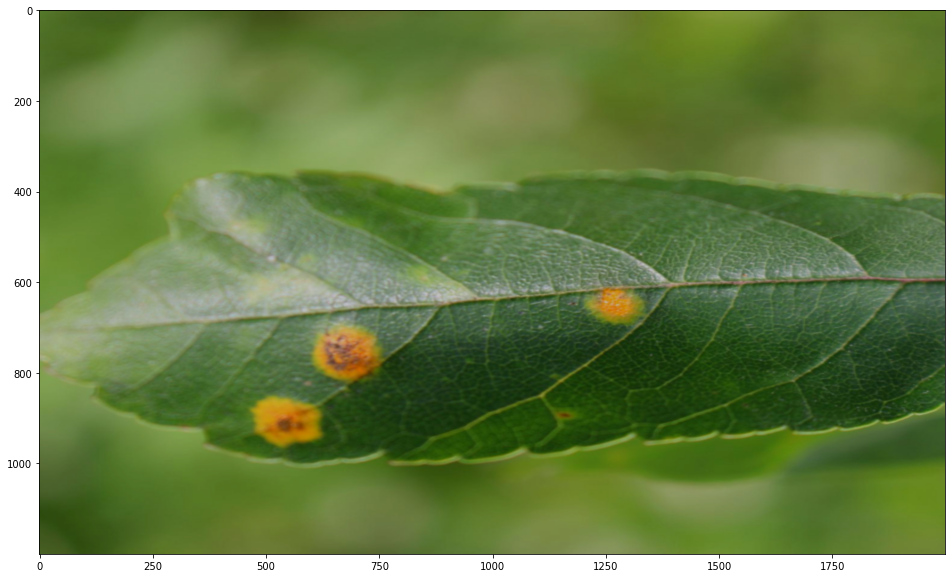

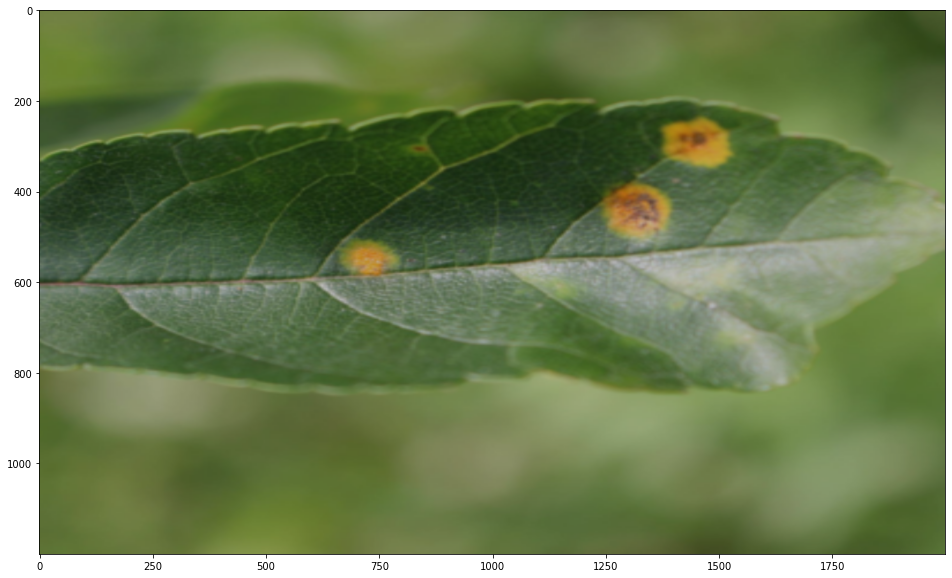

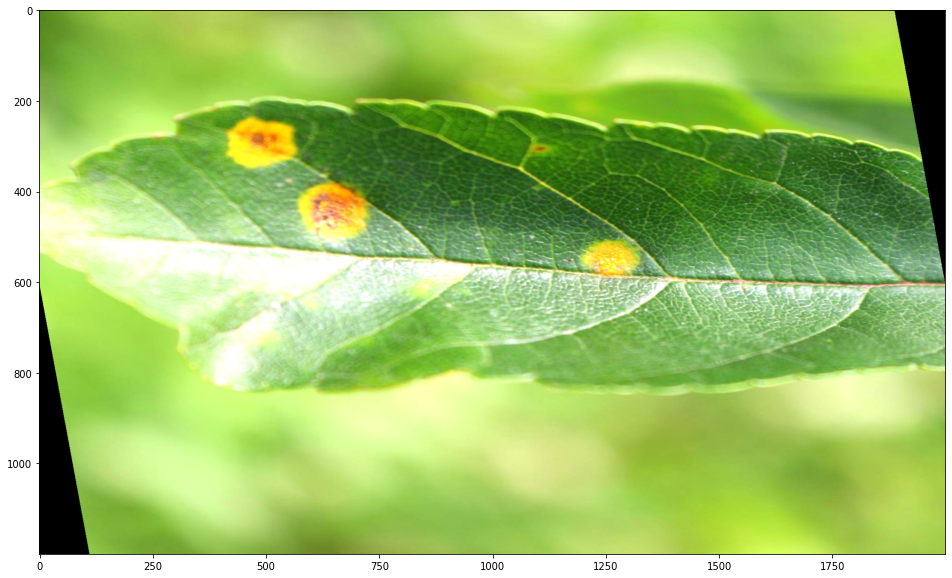

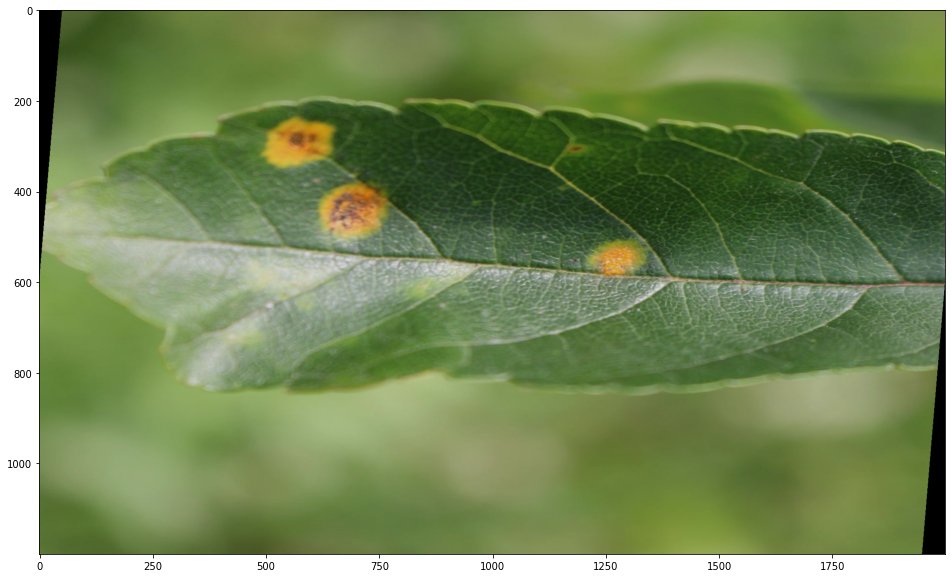

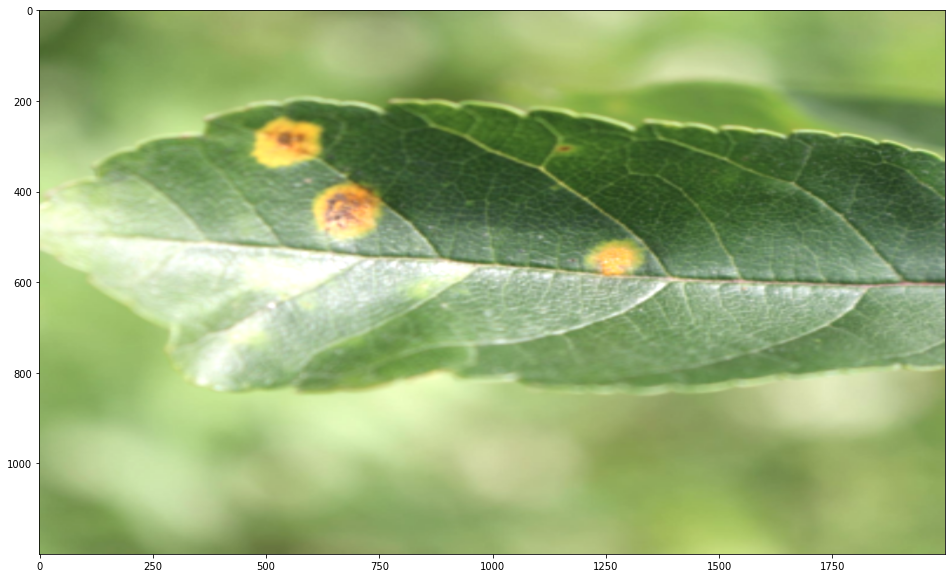

In [ ]:
# to see how the images are being augmented
for i in range(5):
  fig, ax = plt.subplots(figsize=(20,10))
  plt.imshow(np.array(dataset_train[3][0].permute(1,2,0)))
  plt.show()

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=64, num_workers=4, shuffle=True)

In [ ]:
device = torch.device("cuda:0")

In [ ]:
SEED = 42
N_FOLDS = 5
N_EPOCHS = 10
BATCH_SIZE = 64
SIZE = 512

In [ ]:
class PlantModel(nn.Module):
    
    def __init__(self, num_classes=4):
        super().__init__()
        
        self.backbone = torchvision.models.resnet18(pretrained=True)
        
        in_features = self.backbone.fc.in_features

        self.logit = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        batch_size, C, H, W = x.shape
        
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        x = F.dropout(x, 0.25, self.training)

        x = self.logit(x)

        return x

# Canny Edge Detecting
### Here we create bounding boxes using the canny edge detector to help the alogithm produce more accurate results. From the pictures below we can see it does a good job of creating a bounding box on most images.

In [ ]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 150, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] > 20:
                edge_coors.append((i, j))
    
    # Find edges
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    # the four red lines for box with 20 pixel thickness
    emb_img[row_min-10:row_min+10, col_min:col_max] = [0, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [0, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [0, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [0, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

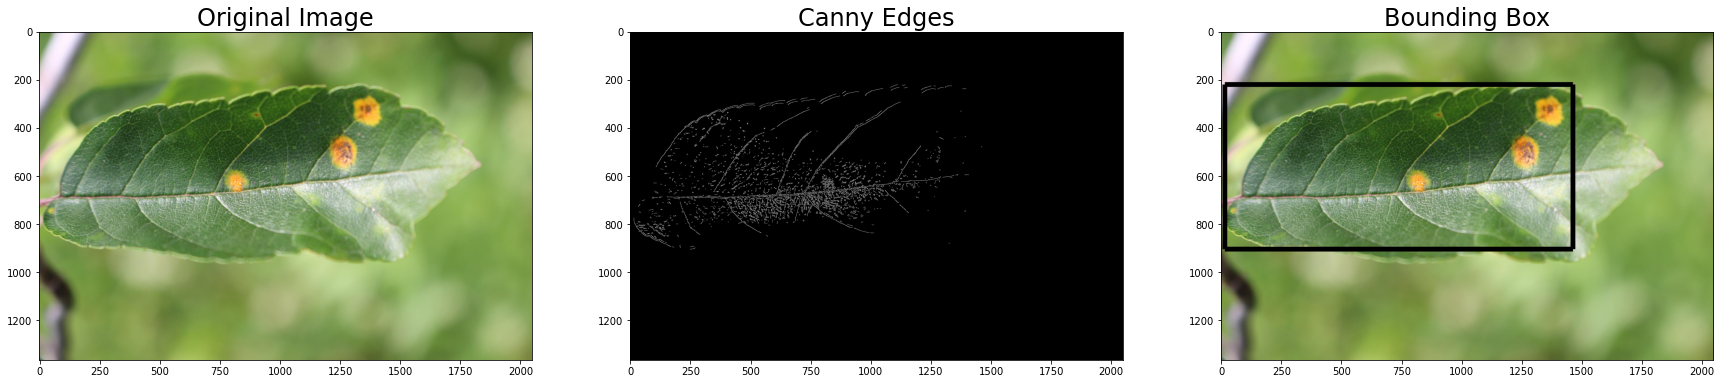

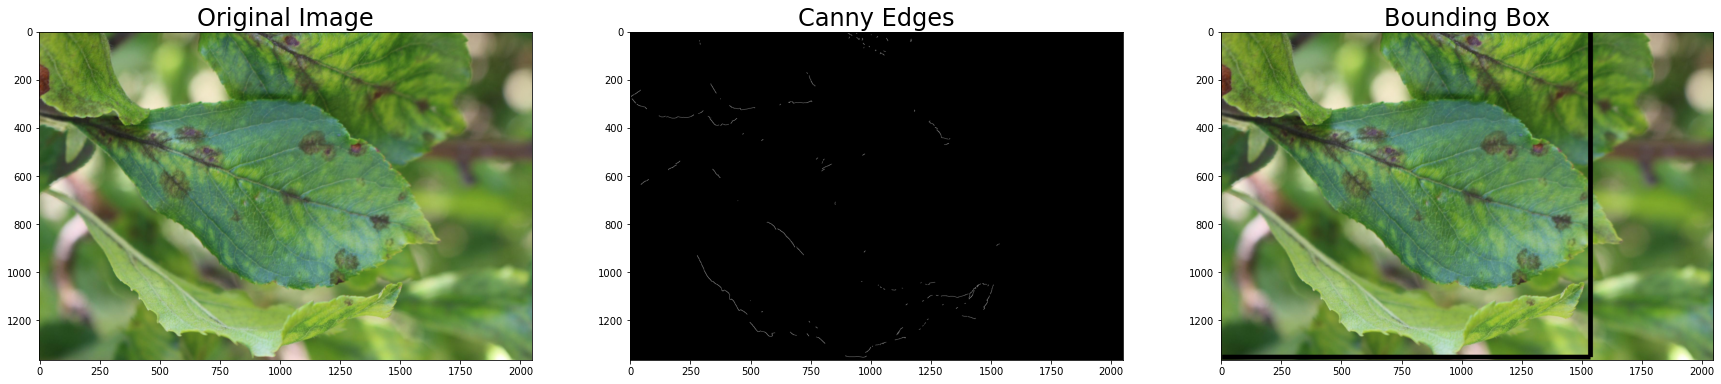

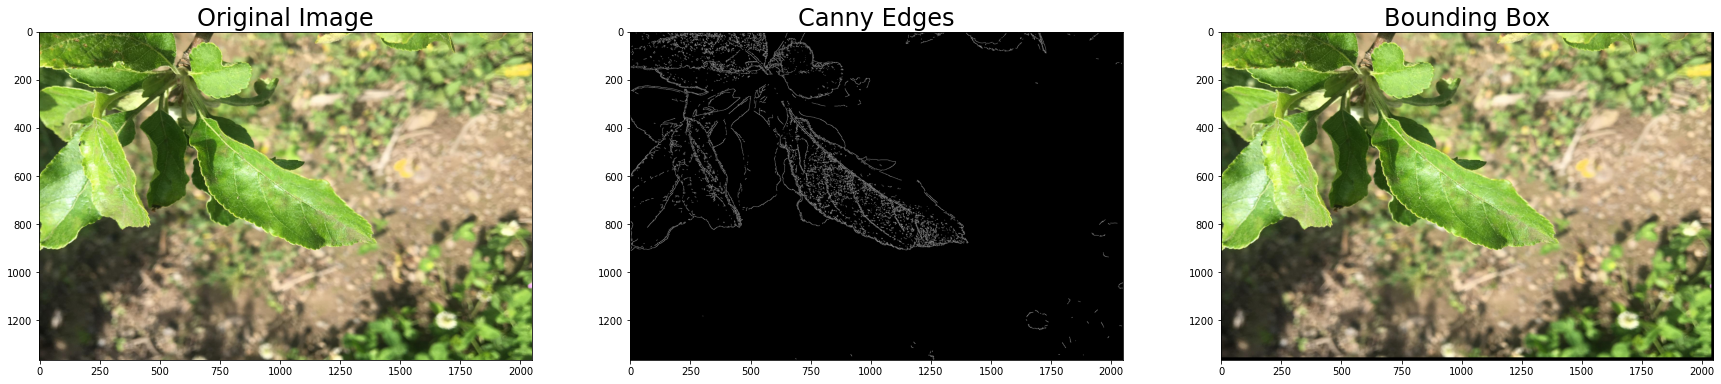

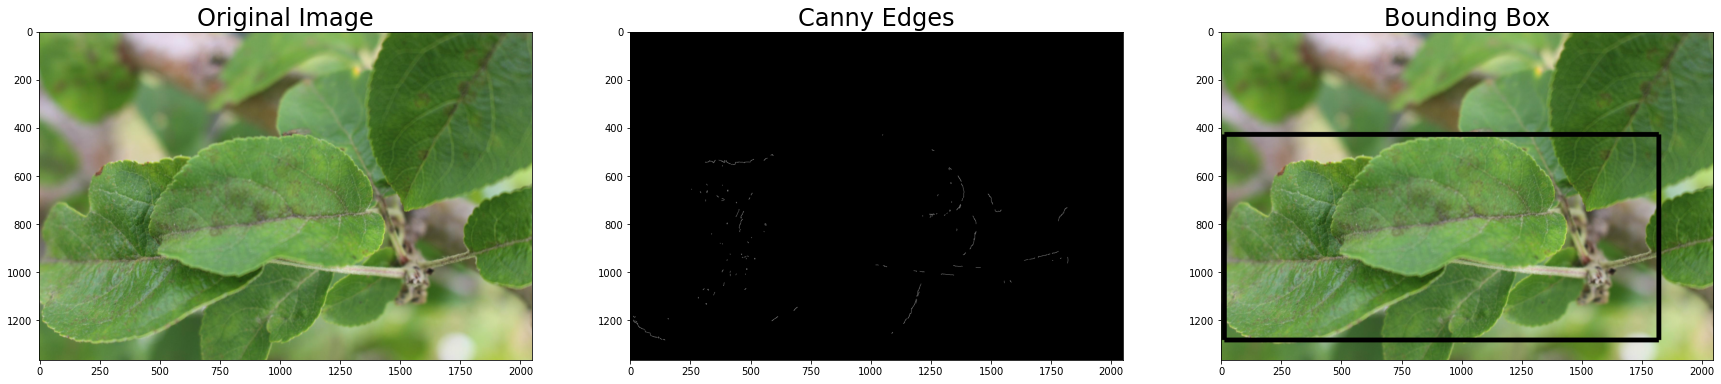

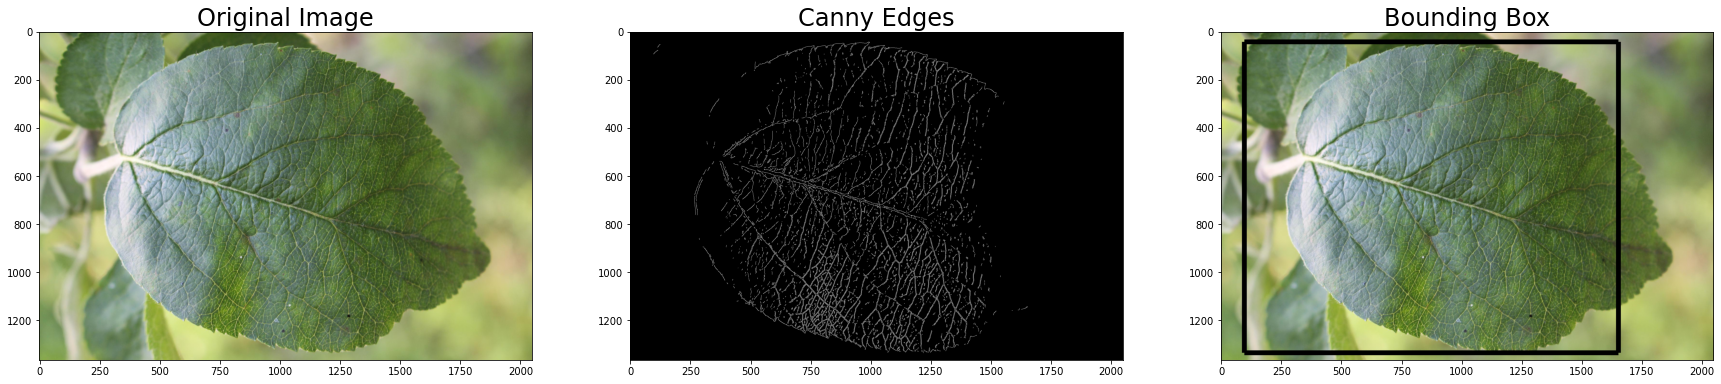

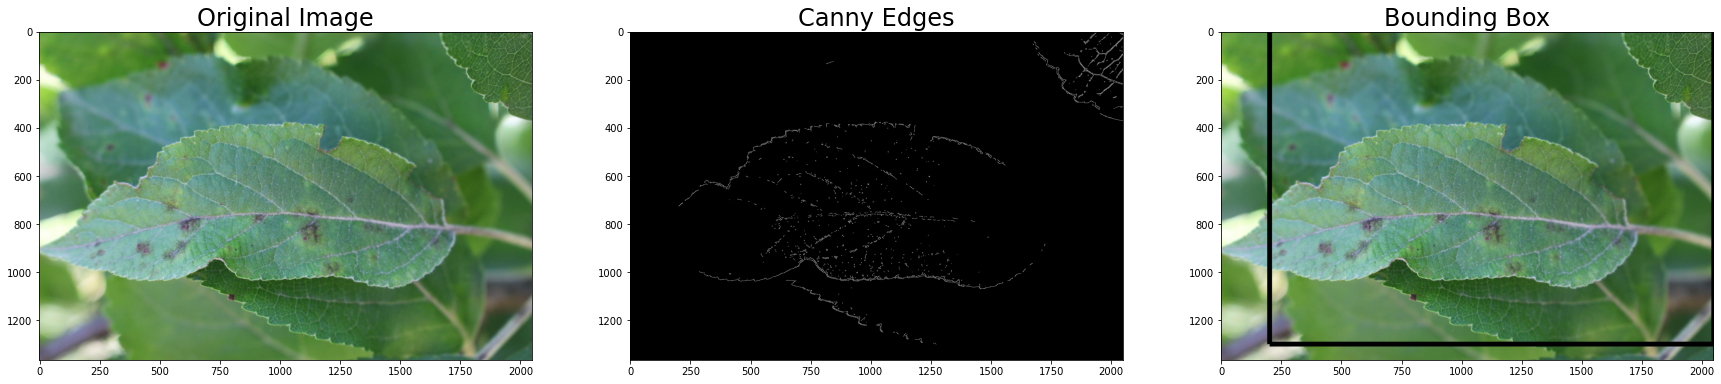

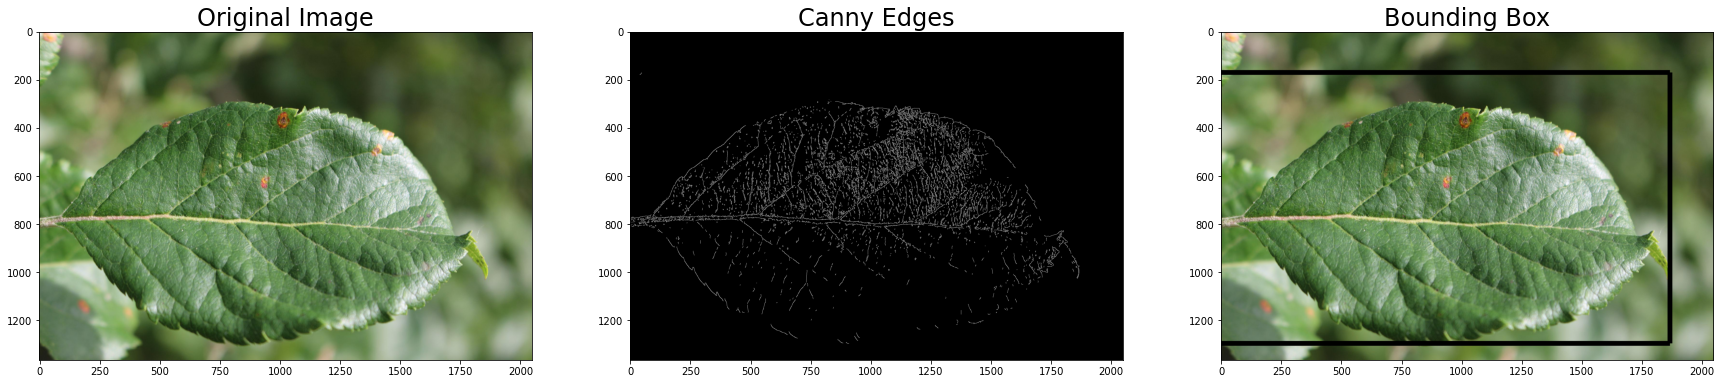

In [ ]:
edge_and_cut(train_images[3])
edge_and_cut(train_images[80])
edge_and_cut(train_images[27])
edge_and_cut(train_images[20])
edge_and_cut(train_images[5])
edge_and_cut(train_images[76])
edge_and_cut(train_images[98])

In [ ]:
ccrop = torchvision.transforms.CenterCrop(10)

#plt.imshow(img0)

In [ ]:
type(train_images)

pandas.core.series.Series

(100,)